# Klasifikasi pada Dataset Yawn Eye

Klasifikasi dilakukan dengan menggunakan transfer learning dari pre-trained VGG16. Pemodelan dilakukan dengan membagi dataset ke dalam subset pelatihan, subset validasi, dan subset pengujian. Evaluasi model dilakukan dengan menggunakan metrik akurasi, presisi, recall, dan f1-score.

In [1]:
#library yang digunakan

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#melihat folder pada direktori

path = '/kaggle/input/dataset_new'
print(os.listdir(path))

['test', 'train']


In [3]:
#membuat path

train_path = path + '/train'
test_path = path + '/test'

In [4]:
#melihat nama kelas

train_classes = os.listdir(train_path)
print(train_classes)
test_classes = os.listdir(test_path)
print(test_classes)

['Closed', 'Open', 'yawn', 'no_yawn']
['Closed', 'Open', 'yawn', 'no_yawn']


In [5]:
#menetukan ukuran data citra dan banyak channel

img_size = 224
no_channel = 3

In [6]:
#pada subset pelatihan: data citra menjadi variabel X dan kelas menjadi variabel y

X_tr = []
y_tr = []
for label in train_classes:
    data_path = os.path.join(train_path, label)
    class_num = train_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_tr.append(resized_arr)
                y_tr.append(class_num)
            except Exception as e:
                print(e)

In [7]:
#pada subset pelatihan: normalisasi min-max untuk variabel X dan pengkodean one-hot untuk variabel y

X_tr = np.asarray(X_tr)
X_tr = X_tr/255
y_tr = np.asarray(y_tr)
y_tr = to_categorical(y_tr)

In [8]:
#membagi subset pelatihan kedalam 80% subset pelatihan dan 20% subset validasi

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size = 0.2, random_state = 1)

In [9]:
#pada subset pengujian: data citra menjadi variabel X dan kelas menjadi variabel y

X_test = []
y_test = []
for label in test_classes:
    data_path = os.path.join(test_path, label)
    class_num = test_classes.index(label)
    for img in os.listdir(data_path):
            try:
                img_arr = cv2.imread(os.path.join(data_path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                X_test.append(resized_arr)
                y_test.append(class_num)
            except Exception as e:
                print(e)

In [10]:
#pada subset pengujian: normalisasi min-max untuk variabel X dan pengkodean one-hot untuk variabel y

X_test = np.asarray(X_test)
X_test = X_test/255
y_test = np.asarray(y_test)
y_test = to_categorical(y_test)

In [11]:
#menampilkan shape dari setiap variabel pada seluruh subset

print('X pelatihan shape :', X_tr.shape)
print('y pelatihan shape :', y_tr.shape)
print('X validasi shape :', X_val.shape)
print('y validasi shape :', y_val.shape)
print('X pengujian shape :', X_test.shape)
print('y pengujian shape :', y_test.shape)

X pelatihan shape : (1973, 224, 224, 3)
y pelatihan shape : (1973, 4)
X validasi shape : (494, 224, 224, 3)
y validasi shape : (494, 4)
X pengujian shape : (433, 224, 224, 3)
y pengujian shape : (433, 4)


In [12]:
#augmentasi data pada subset pelatihan

datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening = False, # apply ZCA whitening
        rotation_range = 0, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image
        width_shift_range = 0.125, # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.125, # randomly shift images vertically (fraction of total height)
        horizontal_flip = True, # randomly flip images
        vertical_flip = False) # randomly flip images
datagen.fit(X_tr)

In [13]:
#mendefinisikan model drowsiness detection menggunakan transfer learning dari pre-trained VGG16

model_VGG16 = VGG16(include_top = False, input_shape = (img_size, img_size, no_channel), weights = 'imagenet')

for layer in model_VGG16.layers:
  layer.trainable = False

inp = model_VGG16.input
x = model_VGG16.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(4, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)

In [14]:
#melihat model yang terbentuk

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
#compile model

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy'])

In [16]:
#menentukan banyak epochs

epochs = 10

In [17]:
#pelatihan model

hist = model.fit(X_tr,
                 y_tr,
                 epochs = epochs,
                 validation_data = (X_val, y_val))

Epoch 1/10
62/62 [==============================] - 14s 143ms/step - loss: 182.1908 - accuracy: 0.6893 - val_loss: 0.4174 - val_accuracy: 0.7328
Epoch 2/10
62/62 [==============================] - 5s 85ms/step - loss: 6157.5293 - accuracy: 0.7258 - val_loss: 0.3211 - val_accuracy: 0.8462
Epoch 3/10
62/62 [==============================] - 5s 86ms/step - loss: 1003.1995 - accuracy: 0.7816 - val_loss: 0.3762 - val_accuracy: 0.8219
Epoch 4/10
62/62 [==============================] - 5s 86ms/step - loss: 714.3152 - accuracy: 0.7922 - val_loss: 0.3409 - val_accuracy: 0.8259
Epoch 5/10
62/62 [==============================] - 5s 86ms/step - loss: 387.6197 - accuracy: 0.8459 - val_loss: 0.2672 - val_accuracy: 0.8866
Epoch 6/10
62/62 [==============================] - 5s 86ms/step - loss: 106.6495 - accuracy: 0.8566 - val_loss: 0.2380 - val_accuracy: 0.9008
Epoch 7/10
62/62 [==============================] - 5s 86ms/step - loss: 43.3234 - accuracy: 0.8738 - val_loss: 0.2367 - val_accuracy: 0.8

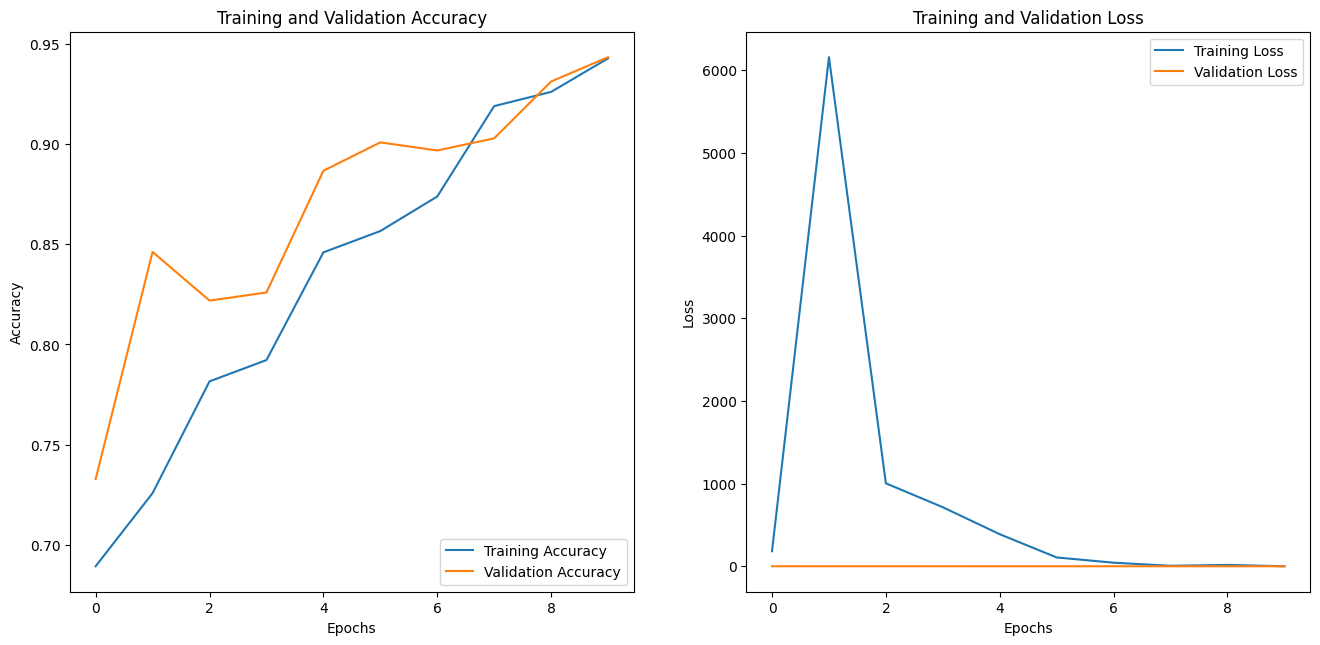

In [18]:
#grafik akurasi dan loss pada pelatihan model

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (16, 16))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [19]:
#prediksi

pred_X = model.predict(X_test)
y_pred = np.argmax(pred_X, axis = 1)
y_test = np.argmax(y_test, axis = 1)

14/14 [==============================] - 2s 153ms/step


Text(0.5, 1.0, 'CNN Confusion Matrix')

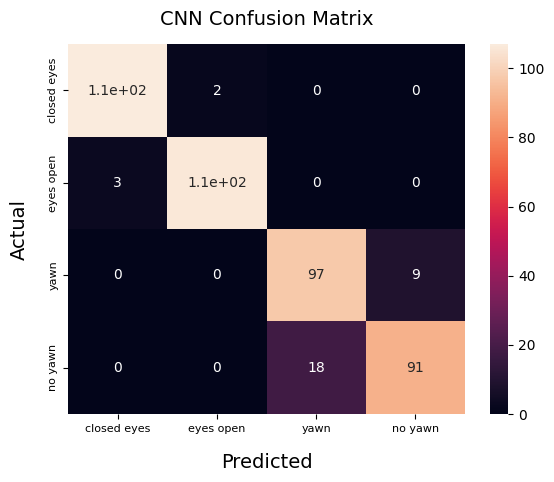

In [20]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred)
hm = sns.heatmap(cm, annot = True)
hm.set_xlabel("Predicted", fontsize = 14, labelpad = 14)
hm.xaxis.set_ticklabels(['closed eyes', 'eyes open', 'yawn', 'no yawn'], fontsize = 8)
hm.set_ylabel("Actual", fontsize = 14, labelpad = 14)
hm.yaxis.set_ticklabels(['closed eyes', 'eyes open', 'yawn', 'no yawn'], fontsize = 8)
hm.set_title("CNN Confusion Matrix", fontsize = 14, pad = 14)

In [21]:
#classification report

print(classification_report(y_test, y_pred, target_names = ['closed eyes', 'eyes open', 'yawn', 'no yawn']))

              precision    recall  f1-score   support

 closed eyes       0.97      0.98      0.98       109
   eyes open       0.98      0.97      0.98       109
        yawn       0.84      0.92      0.88       106
     no yawn       0.91      0.83      0.87       109

    accuracy                           0.93       433
   macro avg       0.93      0.93      0.93       433
weighted avg       0.93      0.93      0.93       433



> * interpretasi

1. precision

precision untuk kelas closed eyes adalah sebesar 0.97, artinya model dapat memprediksi 97% data pada kelas closed eyes dengan benar

precision untuk kelas eyes open adalah sebesar 0.98, artinya model dapat memprediksi 98% data pada kelas eyes open dengan benar

precision untuk kelas yawn adalah sebesar 0.84, artinya model dapat memprediksi 84% data pada kelas yawn dengan benar

precision untuk kelas no yawn adalah sebesar 0.91, artinya model dapat memprediksi 91% data pada kelas no yawn dengan benar

rata-rata precision adalah sebesar 0.93, artinya model dapat memprediksi rata-rata 93% data dengan benar

1. recall

recall untuk kelas closed eyes adalah sebesar 0.98, artinya model dapat menghasilkan 98% prediksi yang tepat pada kelas closed eyes

recall untuk kelas eyes open adalah sebesar 0.97, artinya model dapat menghasilkan 97% prediksi yang tepat pada kelas eyes open

recall untuk kelas yawn adalah sebesar 0.92, artinya model dapat menghasilkan 92% prediksi yang tepat pada kelas yawn

recall untuk kelas no yawn adalah sebesar 0.83, artinya model dapat menghasilkan 83% prediksi yang tepat pada kelas no yawn

rata-rata recall adalah sebesar 0.93, artinya model dapat menghasilkan rata-rata 93% prediksi yang tepat

1. f1-score

f1-score untuk kelas closed eyes adalah sebesar 0.98, artinya kemampuan model untuk dapat memprediksi data dengan benar dan menghasilkan prediksi yang tepat pada kelas closed eyes adalah sebesar 98%

f1-score untuk kelas eyes open adalah sebesar 0.98, artinya kemampuan model untuk dapat memprediksi data dengan benar dan menghasilkan prediksi yang tepat pada kelas eyes open adalah sebesar 98%

f1-score untuk kelas yawn adalah sebesar 0.88, artinya kemampuan model untuk dapat memprediksi data dengan benar dan menghasilkan prediksi yang tepat pada kelas yawn adalah sebesar 88%

f1-score untuk kelas no yawn adalah sebesar 0.87, artinya kemampuan model untuk dapat memprediksi data dengan benar dan menghasilkan prediksi yang tepat pada kelas no yawn adalah sebesar 87%

rata-rata f1-score adalah sebesar 0.93, artinya rata-rata kemampuan model untuk dapat memprediksi data dengan benar dan menghasilkan prediksi yang tepat adalah sebesar 93%

1. accuracy

model memiliki akurasi sebesar 0.93, artinya kemampuan model untuk dapat menghasilkan prediksi dengan benar dan tepat dari keseluhuran data yang ada adalah sebesar 93%